--- 
# Crop Disease Detection Project
---

In [ ]:
import os
import numpy as np
import joblib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

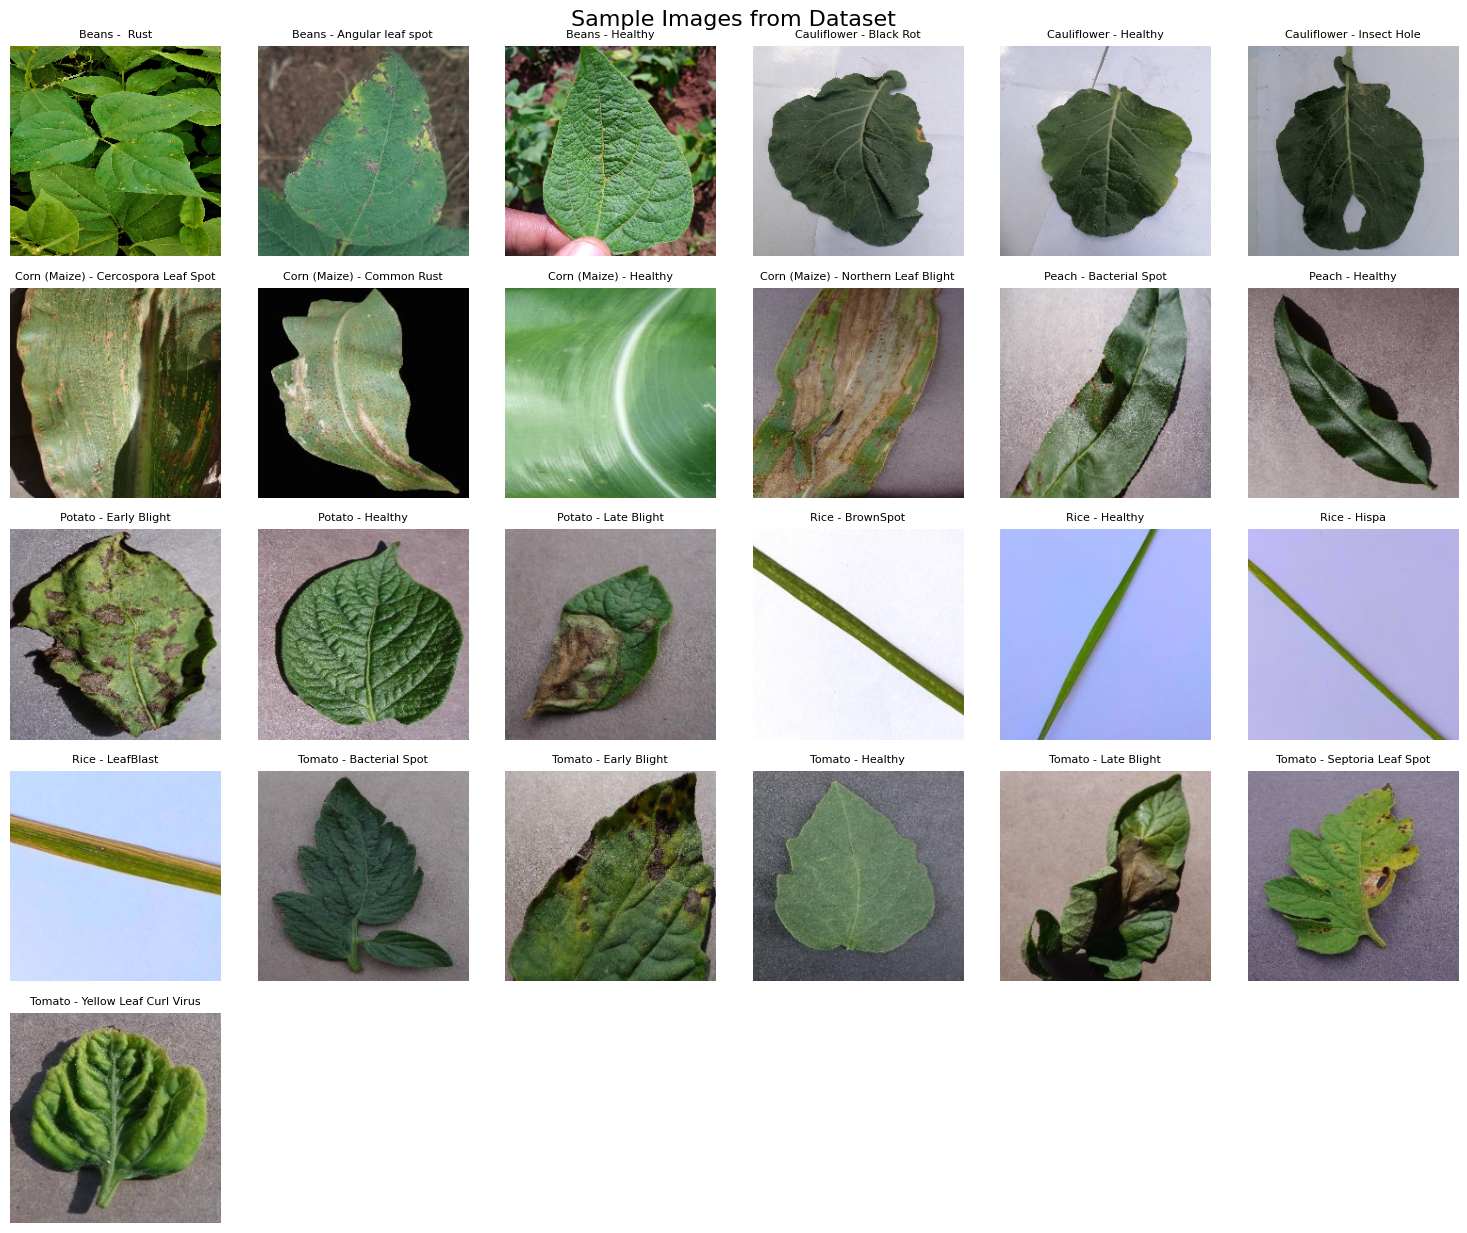

In [ ]:
# Path to the dataset folder
dataset_path = r"E:\Year 4, Sem 1\APC419_Computer Vision\Project\croproject\Data"
img_size = 224

# Get list of class folders
classes = sorted(os.listdir(dataset_path))

# Display one sample image per class
plt.figure(figsize=(15, 15))
for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue
    
    # Get first image in this class folder
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not img_files:
        continue
    
    img_path = os.path.join(class_path, img_files[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    
    # Plot image
    plt.subplot(6, 6, i + 1)  
    plt.imshow(img)
    plt.title(cls, fontsize=8)
    plt.axis('off')
    
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Check for total number of images in dataset
total_images = 0
class_counts = {}

# Loop through each class folder
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    # Count images in this class
    num_images = len([f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    class_counts[cls] = num_images
    total_images += num_images

# Print per-class and total counts
print("Number of images in each class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print("\nTotal number of images in dataset:", total_images)


Number of images in each class:
Beans -  Rust: 226
Beans - Angular leaf spot: 267
Beans - Healthy: 250
Cauliflower - Black Rot: 1088
Cauliflower - Healthy: 934
Cauliflower - Insect Hole: 639
Corn (Maize) - Cercospora Leaf Spot: 2011
Corn (Maize) - Common Rust: 2384
Corn (Maize) - Healthy: 2324
Corn (Maize) - Northern Leaf Blight: 2385
Peach - Bacterial Spot: 2297
Peach - Healthy: 2160
Potato - Early Blight: 2424
Potato - Healthy: 2280
Potato - Late Blight: 2424
Rice - BrownSpot: 523
Rice - Healthy: 1488
Rice - Hispa: 565
Rice - LeafBlast: 779
Tomato - Bacterial Spot: 2127
Tomato - Early Blight: 2400
Tomato - Healthy: 2407
Tomato - Late Blight: 2314
Tomato - Septoria Leaf Spot: 2181
Tomato - Yellow Leaf Curl Virus: 2451

Total number of images in dataset: 41328


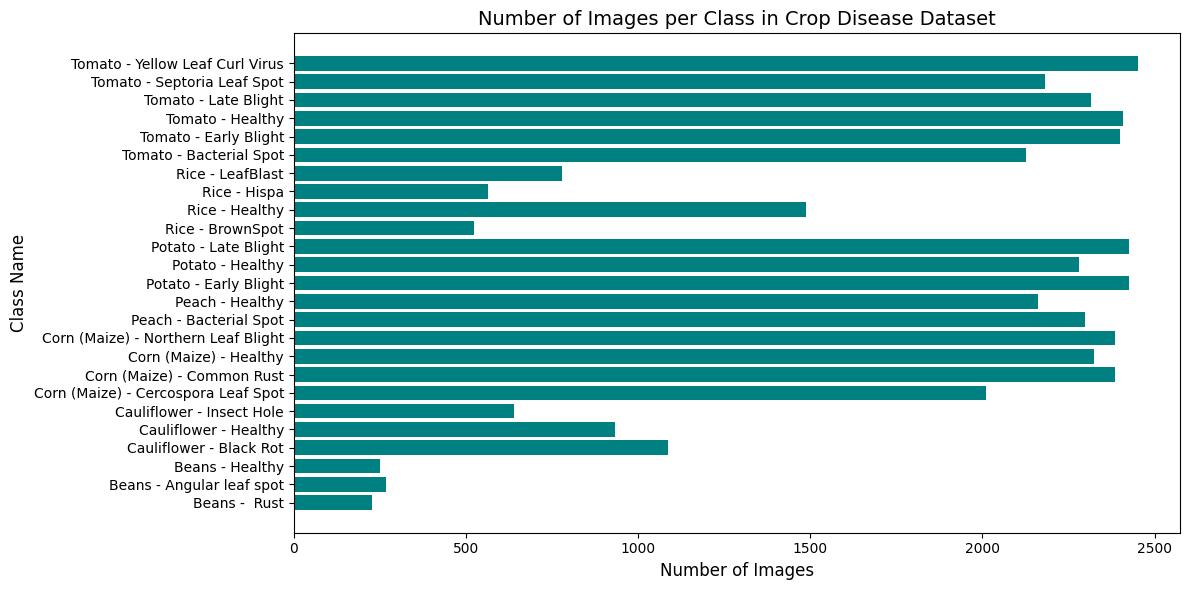

In [ ]:
# Visualization 
plt.figure(figsize=(12, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='teal')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class Name', fontsize=12)
plt.title('Number of Images per Class in Crop Disease Dataset', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Number of classes 
print("Total number of classes:", len(class_counts))

Total number of classes: 25


In [ ]:
# Augmentation for training and normalization for validation
batch_size = 32
img_size = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training and validation generators (80% train, 20% val)
train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# Save class names for later use
class_names = list(train_gen.class_indices.keys())
joblib.dump(class_names, "leaf_class_names.pkl")
print("Classes:", class_names)

Found 33073 images belonging to 25 classes.
Found 8255 images belonging to 25 classes.
Classes: ['Beans -  Rust', 'Beans - Angular leaf spot', 'Beans - Healthy', 'Cauliflower - Black Rot', 'Cauliflower - Healthy', 'Cauliflower - Insect Hole', 'Corn (Maize) - Cercospora Leaf Spot', 'Corn (Maize) - Common Rust', 'Corn (Maize) - Healthy', 'Corn (Maize) - Northern Leaf Blight', 'Peach - Bacterial Spot', 'Peach - Healthy', 'Potato - Early Blight', 'Potato - Healthy', 'Potato - Late Blight', 'Rice - BrownSpot', 'Rice - Healthy', 'Rice - Hispa', 'Rice - LeafBlast', 'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Healthy', 'Tomato - Late Blight', 'Tomato - Septoria Leaf Spot', 'Tomato - Yellow Leaf Curl Virus']


### Model Building (MobileNet)

In [ ]:
# Build model using MobileNetV2 base
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,592,345 (9.89 MB)

 Trainable params: 334,361 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("mobilenet_leaf_model.h5", monitor='val_accuracy', save_best_only=True)
]


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


e:\Year 4, Sem 1\APC419_Computer Vision\Project\croproject\cvenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4484 - loss: 1.8853

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1604s 2s/step - accuracy: 0.6087 - loss: 1.2577 - val_accuracy: 0.7983 - val_loss: 0.5834
Epoch 2/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7684 - loss: 0.6811

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 10551s 10s/step - accuracy: 0.7793 - loss: 0.6417 - val_accuracy: 0.8247 - val_loss: 0.4737
Epoch 3/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8077 - loss: 0.5445

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 8278s 8s/step - accuracy: 0.8116 - loss: 0.5320 - val_accuracy: 0.8376 - val_loss: 0.4295
Epoch 4/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8301 - loss: 0.4809

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 2835s 3s/step - accuracy: 0.8295 - loss: 0.4764 - val_accuracy: 0.8475 - val_loss: 0.4073
Epoch 5/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8380 - loss: 0.4480

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.8418 - loss: 0.4387 - val_accuracy: 0.8531 - val_loss: 0.3780
Epoch 6/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8501 - loss: 0.4140

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1957s 2s/step - accuracy: 0.8480 - loss: 0.4146 - val_accuracy: 0.8589 - val_loss: 0.3676
Epoch 7/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1707s 2s/step - accuracy: 0.8532 - loss: 0.3983 - val_accuracy: 0.8538 - val_loss: 0.3661
Epoch 8/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8600 - loss: 0.3839

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 2149s 2s/step - accuracy: 0.8585 - loss: 0.3855 - val_accuracy: 0.8640 - val_loss: 0.3614
Epoch 9/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8649 - loss: 0.3669

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 3206s 3s/step - accuracy: 0.8643 - loss: 0.3715 - val_accuracy: 0.8648 - val_loss: 0.3417
Epoch 10/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1707s 2s/step - accuracy: 0.8688 - loss: 0.3583 - val_accuracy: 0.8647 - val_loss: 0.3402
Epoch 11/30
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8694 - loss: 0.3511

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 1584s 2s/step - accuracy: 0.8706 - loss: 0.3474 - val_accuracy: 0.8665 - val_loss: 0.3366
Epoch 12/30
 448/1034 ━━━━━━━━━━━━━━━━━━━━ 13:37 1s/step - accuracy: 0.8727 - loss: 0.3386

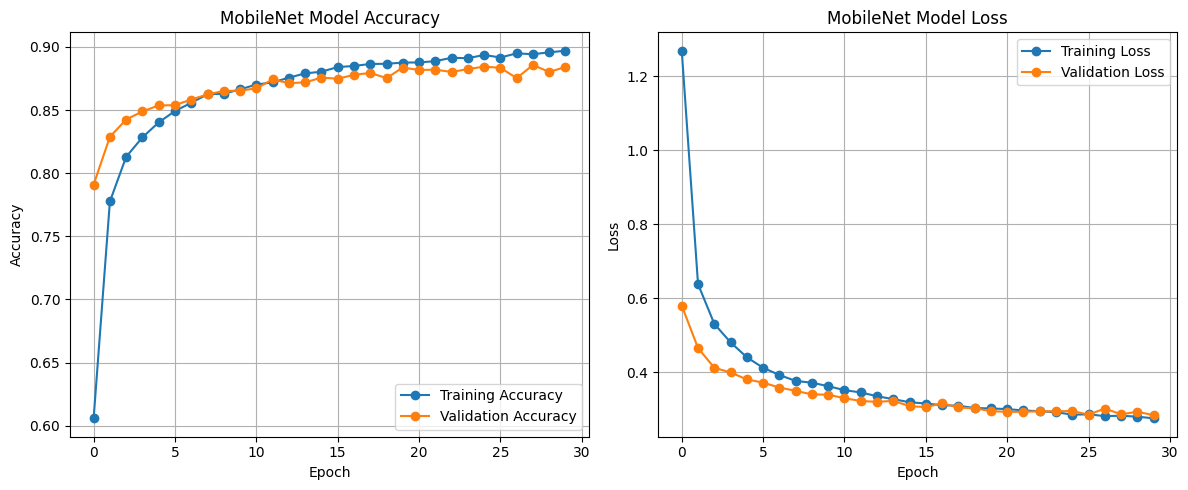

In [ ]:
# Plot training & validation accuracy 
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('MobileNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('MobileNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")

# Save model for later
# model.save("mobilenet_leaf_model.h5")


258/258 ━━━━━━━━━━━━━━━━━━━━ 149s 577ms/step - accuracy: 0.8841 - loss: 0.2869
Validation Accuracy: 88.41%


In [ ]:
# Recreate validation generator properly
val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,   #  MUST be False
    seed=42          # ensures consistent split
)

Found 8255 images belonging to 25 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import joblib

val_gen.reset()

# Predict on validation set
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Manual accuracy check
manual_acc = np.sum(y_true == y_pred_classes) / len(y_true)
print(f"Manual Accuracy Check: {manual_acc * 100:.2f}%")

# Load class names
class_names = joblib.load("leaf_class_names.pkl")
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    zero_division=0 
))


e:\Year 4, Sem 1\APC419_Computer Vision\Project\croproject\cvenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


258/258 ━━━━━━━━━━━━━━━━━━━━ 129s 496ms/step
Manual Accuracy Check: 88.33%

Classification Report:
                                     precision    recall  f1-score   support

                      Beans -  Rust       1.00      1.00      1.00        45
          Beans - Angular leaf spot       0.96      1.00      0.98        53
                    Beans - Healthy       1.00      0.96      0.98        50
            Cauliflower - Black Rot       0.63      0.82      0.71       217
              Cauliflower - Healthy       0.72      0.39      0.50       186
          Cauliflower - Insect Hole       0.50      0.58      0.54       127
Corn (Maize) - Cercospora Leaf Spot       0.89      0.91      0.90       402
         Corn (Maize) - Common Rust       0.98      0.99      0.99       476
             Corn (Maize) - Healthy       1.00      1.00      1.00       464
Corn (Maize) - Northern Leaf Blight       0.93      0.91      0.92       477
             Peach - Bacterial Spot       0.99      0

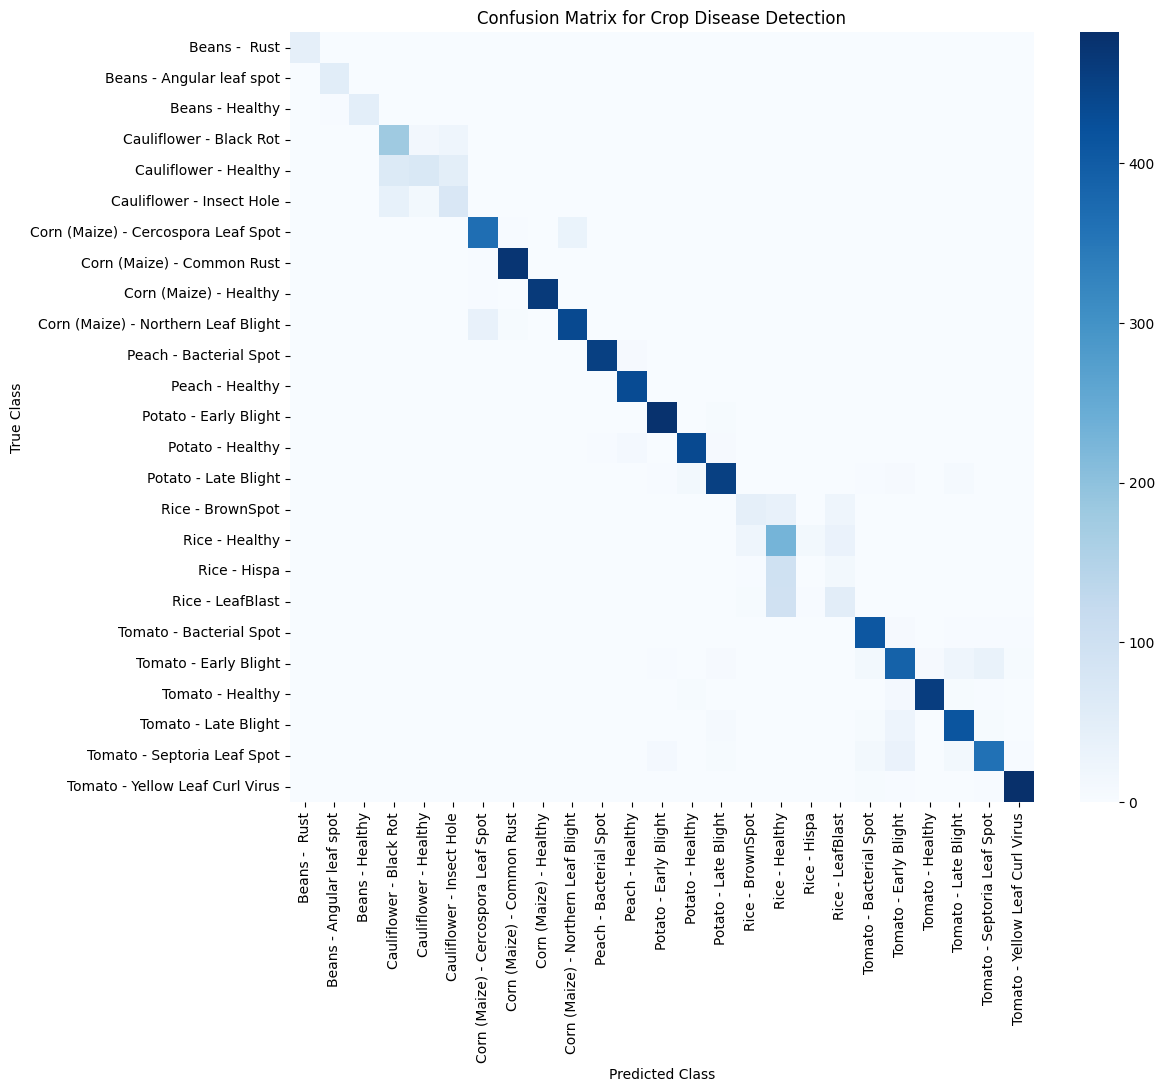

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Crop Disease Detection")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


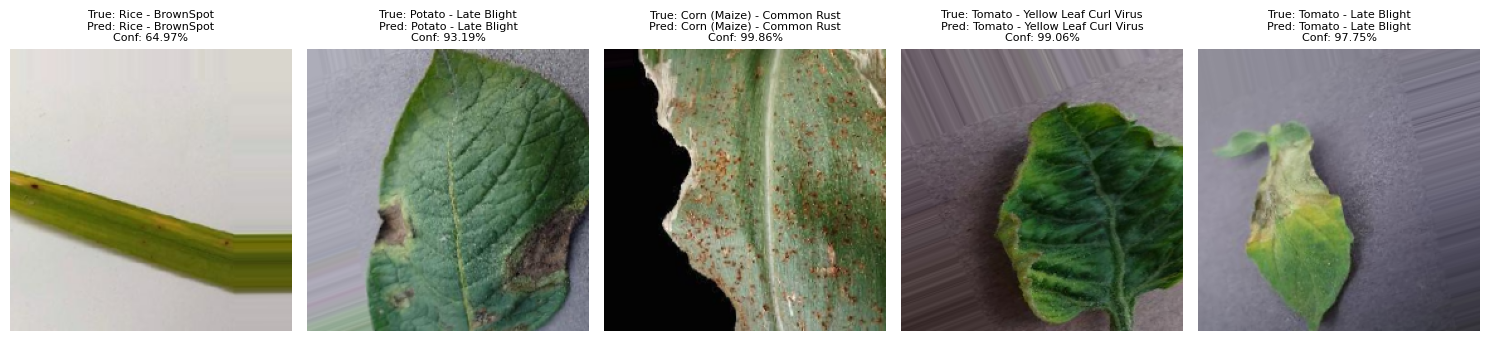

In [ ]:
# Visualize some predictions
class_labels = list(val_gen.class_indices.keys())

# Choose random sample images from validation set
sample_batch, sample_labels = next(val_gen)
predictions = model.predict(sample_batch)

# Display 5 example predictions
plt.figure(figsize=(15, 4))
for i in range(5):  # Show 5 images
    ax = plt.subplot(1, 5, i + 1)
    
    img = sample_batch[i]
    true_label = class_labels[np.argmax(sample_labels[i])]
    pred_label = class_labels[np.argmax(predictions[i])]
    confidence = np.max(predictions[i]) * 100
    
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:

import os
import cv2
import numpy as np
import joblib
from tensorflow.keras.models import load_model

model = load_model("mobilenet_leaf_model.h5")
class_names = joblib.load("leaf_class_names.pkl")
img_size = 224

# Use a file or a directory here
test_path = r"E:\Year 4, Sem 1\APC419_Computer Vision\Project\croproject\caurot.jpeg"

if os.path.isdir(test_path):
    files = [os.path.join(test_path, f) for f in os.listdir(test_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
elif os.path.isfile(test_path):
    files = [test_path]
else:
    raise FileNotFoundError(f"Test path not found: {test_path}")

for img_path in files:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read: {img_path}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size)).astype("float32") / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    preds = model.predict(img_input)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Predicted Class: {pred_class}")
    print(f"Confidence: {confidence:.2f}%\n")

    label = f"{pred_class} ({confidence:.1f}%)"
    cv2.putText(img, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Prediction", img)
    cv2.waitKey(1000)

cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: caurot.jpeg
Predicted Class: Tomato - Early Blight
Confidence: 40.98%



# Retrain with unknown class label


In [ ]:
# Import Libraries
import os
import joblib
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Dataset Path
dataset_path = r"C:\Users\user\OneDrive\Desktop\Year4,sem1\APC419\Project\croproject\Data"
img_size = 224
batch_size = 32


In [ ]:

# Data Generators (Include Unknown class) 
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_gen.class_indices.keys())
print(" Classes found:", class_names)



Found 33322 images belonging to 26 classes.
Found 8317 images belonging to 26 classes.
✅ Classes found: ['Beans -  Rust', 'Beans - Angular leaf spot', 'Beans - Healthy', 'Cauliflower - Black Rot', 'Cauliflower - Healthy', 'Cauliflower - Insect Hole', 'Corn (Maize) - Cercospora Leaf Spot', 'Corn (Maize) - Common Rust', 'Corn (Maize) - Healthy', 'Corn (Maize) - Northern Leaf Blight', 'Peach - Bacterial Spot', 'Peach - Healthy', 'Potato - Early Blight', 'Potato - Healthy', 'Potato - Late Blight', 'Rice - BrownSpot', 'Rice - Healthy', 'Rice - Hispa', 'Rice - LeafBlast', 'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Healthy', 'Tomato - Late Blight', 'Tomato - Septoria Leaf Spot', 'Tomato - Yellow Leaf Curl Virus', 'Unknown']


In [ ]:
# Load Saved Model
model_path = r"C:\Users\user\OneDrive\Desktop\Year4,sem1\APC419\Project\croproject\mobilenet_leaf_model.h5"
base_model = load_model(model_path)
print(" Loaded existing model.")

# Freeze All Existing Layers
for layer in base_model.layers:
    layer.trainable = False



✅ Loaded existing model.


In [ ]:

# Replace Classification Head with New Dense Layer

x = base_model.layers[-2].output  # layer before final Dense
num_classes = train_gen.num_classes
new_output = Dense(num_classes, activation='softmax', name='output_layer')(x)

# Build new model
model = Model(inputs=base_model.input, outputs=new_output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # slightly higher for top layer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f" Model rebuilt for {num_classes} classes (including Unknown).")


✅ Model rebuilt for 26 classes (including Unknown).


In [ ]:


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet_unknown_only_best.h5", save_best_only=True)

# ============================================================
# Train Only Top Layer (New Dense) on Unknown Class
# ============================================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # usually enough
    callbacks=[early_stop, checkpoint],
    verbose=1
)



Epoch 1/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.6753 - loss: 1.1459

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1283s 1s/step - accuracy: 0.8111 - loss: 0.5918 - val_accuracy: 0.8864 - val_loss: 0.2984
Epoch 2/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8890 - loss: 0.3030

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1095s 1s/step - accuracy: 0.8948 - loss: 0.2877 - val_accuracy: 0.8923 - val_loss: 0.2788
Epoch 3/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9026 - loss: 0.2622

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1067s 1s/step - accuracy: 0.9036 - loss: 0.2596 - val_accuracy: 0.8913 - val_loss: 0.2769
Epoch 4/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9069 - loss: 0.2501

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1029s 988ms/step - accuracy: 0.9059 - loss: 0.2500 - val_accuracy: 0.8961 - val_loss: 0.2662
Epoch 5/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 960s 921ms/step - accuracy: 0.9062 - loss: 0.2483 - val_accuracy: 0.8942 - val_loss: 0.2676
Epoch 6/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 914s 877ms/step - accuracy: 0.9046 - loss: 0.2492 - val_accuracy: 0.8917 - val_loss: 0.2683
Epoch 7/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.9077 - loss: 0.2454 - val_accuracy: 0.8925 - val_loss: 0.2668


In [ ]:
# ============================================================
# Save Model and Updated Class Names
# ============================================================
model.save("mobilenet_unknown_only.h5")
joblib.dump(class_names, "leaf_class_names_with_unknown.pkl")
print(" Retrained model saved with Unknown class.")

✅ Retrained model saved with Unknown class.


In [ ]:
# accuracy
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy after retraining: {acc*100:.2f}%")


260/260 ━━━━━━━━━━━━━━━━━━━━ 243s 927ms/step - accuracy: 0.8961 - loss: 0.2662
Validation Accuracy after retraining: 89.61%


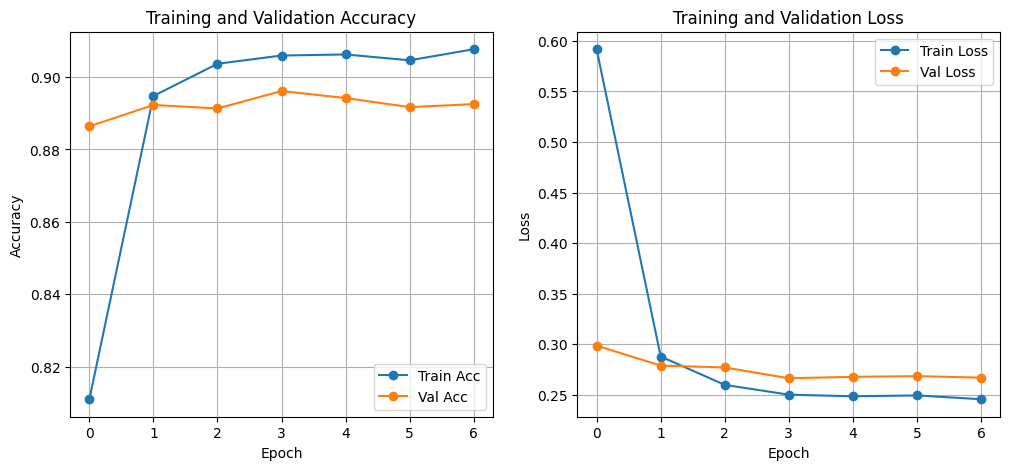

In [ ]:
# Plot Training Curves

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')    
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.grid(True)




In [ ]:
# Recreate validation generator properly
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,   #  MUST be False
    seed=42          # ensures consistent split
)

Found 8317 images belonging to 26 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import joblib

val_gen.reset()

# Predict on validation set
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Manual accuracy check
manual_acc = np.sum(y_true == y_pred_classes) / len(y_true)
print(f"Manual Accuracy Check: {manual_acc * 100:.2f}%")

# Load class names
class_names = joblib.load("leaf_class_names_with_unknown.pkl")
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    zero_division=0 
))

260/260 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step
Manual Accuracy Check: 89.61%

Classification Report:
                                     precision    recall  f1-score   support

                      Beans -  Rust       1.00      0.96      0.98        45
          Beans - Angular leaf spot       0.90      1.00      0.95        53
                    Beans - Healthy       1.00      0.92      0.96        50
            Cauliflower - Black Rot       0.67      0.80      0.73       217
              Cauliflower - Healthy       0.68      0.56      0.62       186
          Cauliflower - Insect Hole       0.64      0.59      0.61       127
Corn (Maize) - Cercospora Leaf Spot       0.97      0.88      0.92       402
         Corn (Maize) - Common Rust       1.00      0.99      1.00       476
             Corn (Maize) - Healthy       0.99      0.99      0.99       464
Corn (Maize) - Northern Leaf Blight       0.90      0.98      0.94       477
             Peach - Bacterial Spot       0.99      0.97

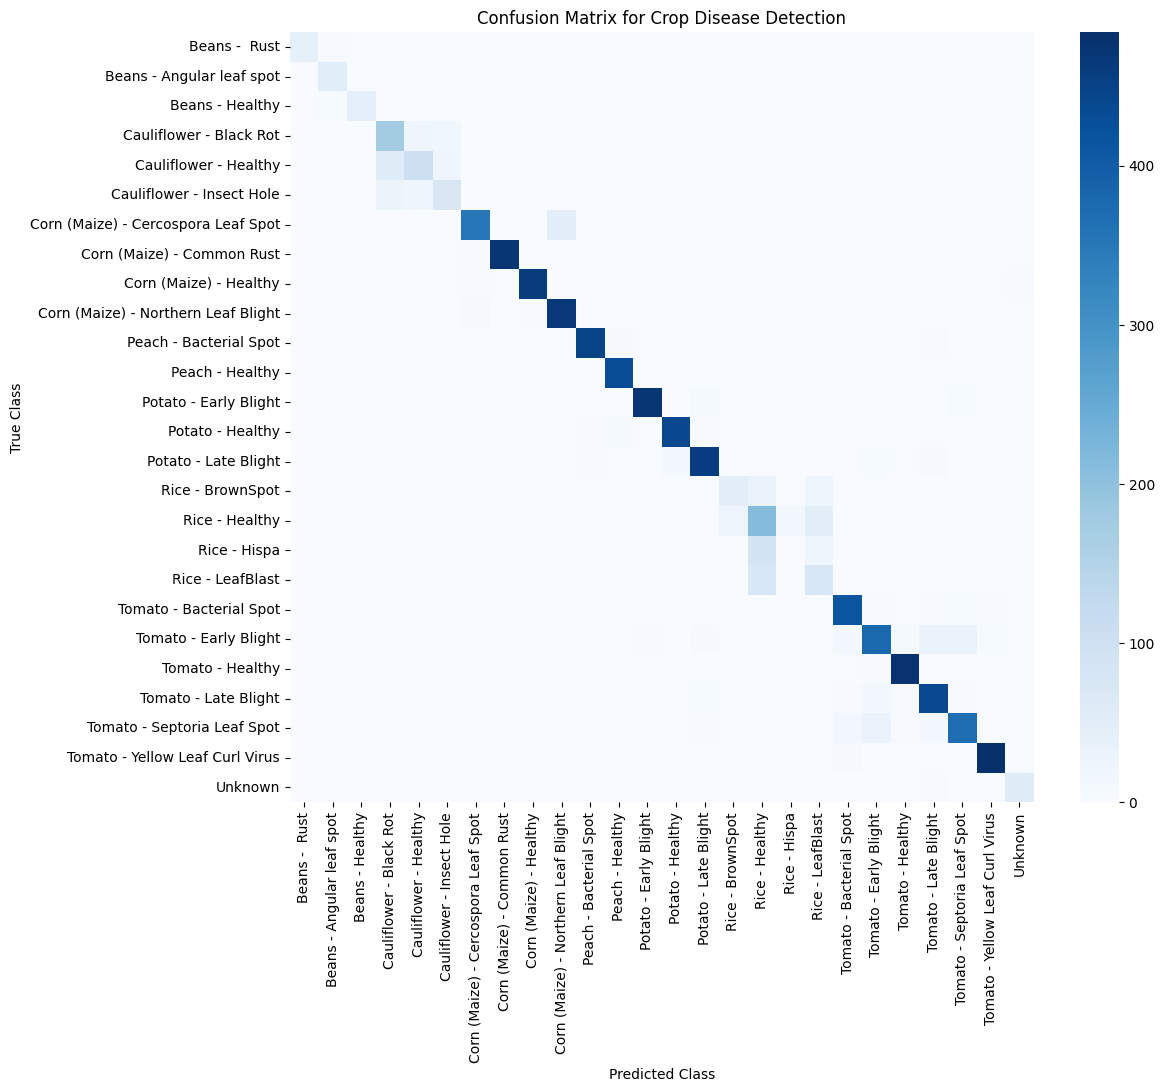

In [ ]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Crop Disease Detection")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# 2nd Model: Custom CNN

In [ ]:
import os
import glob
import cv2
import numpy as np

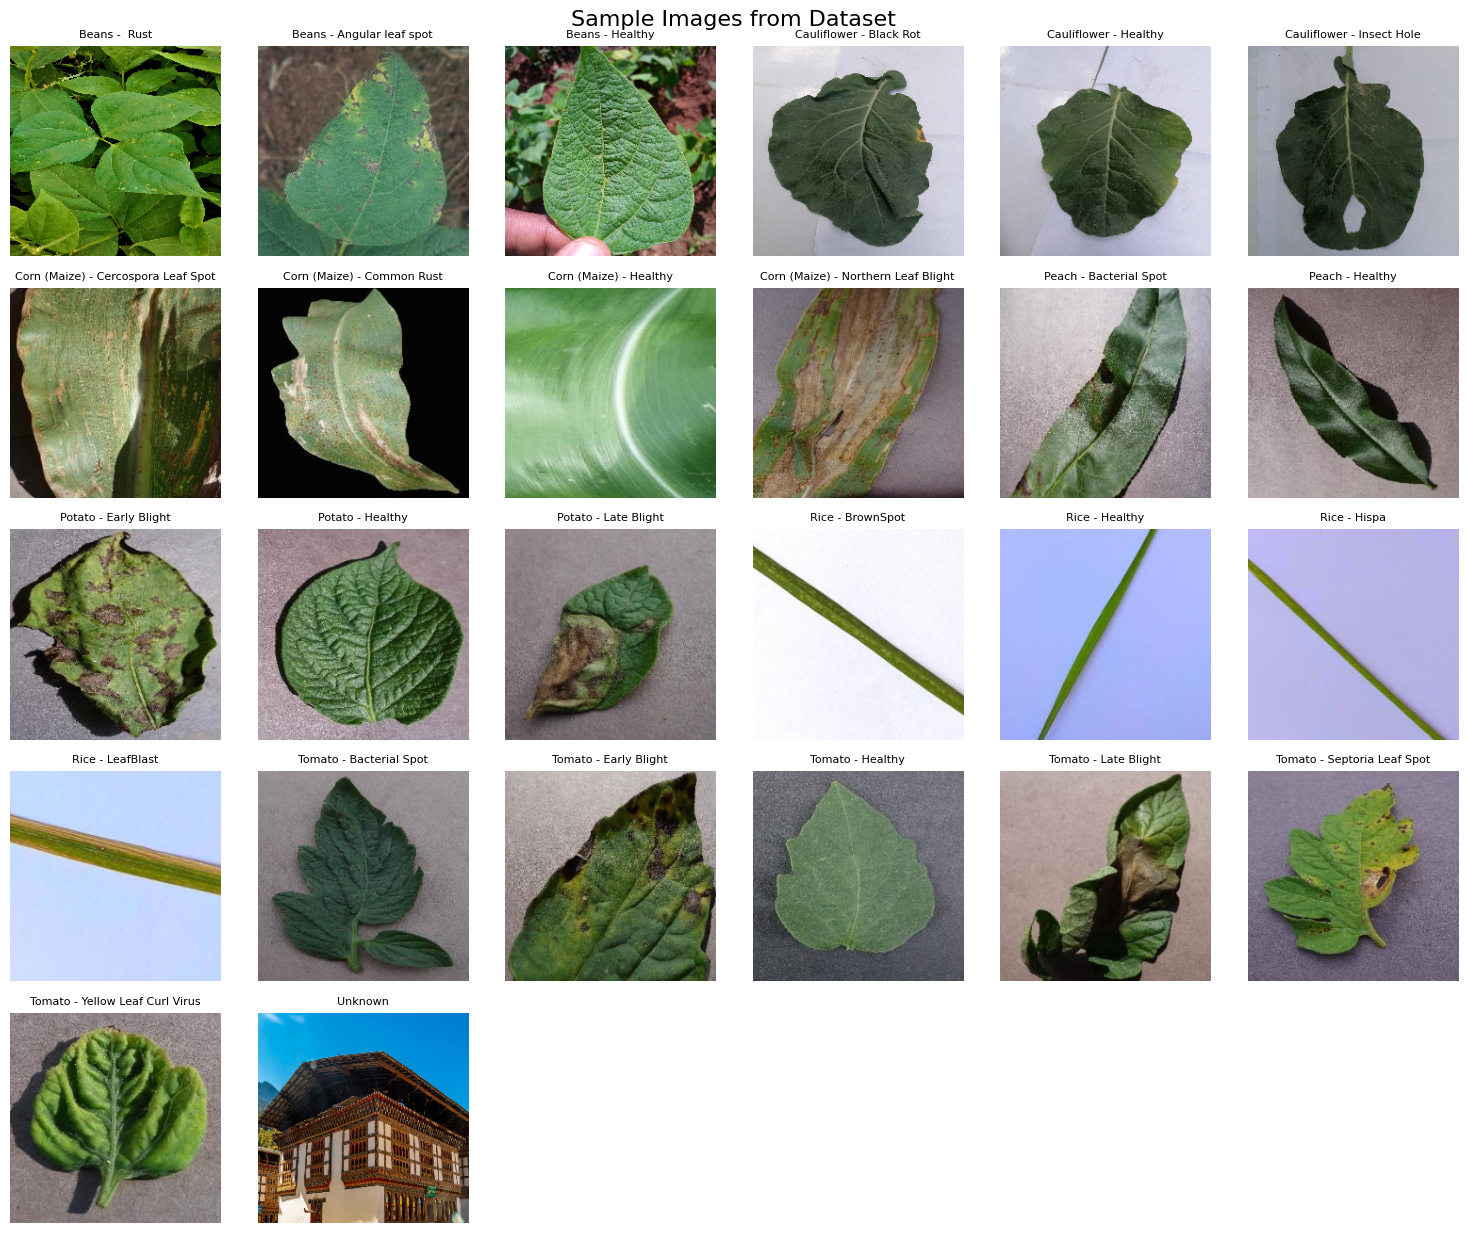

In [ ]:
# Path to the dataset folder
dataset_path = r"C:\Users\user\OneDrive\Desktop\Year4,sem1\APC419\Project\croproject\Data"
img_size = 224

# Get list of class folders
classes = sorted(os.listdir(dataset_path))

# Display one sample image per class
plt.figure(figsize=(15, 15))
for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue
    
    # Get first image in this class folder
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not img_files:
        continue
    
    img_path = os.path.join(class_path, img_files[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    
    # Plot image
    plt.subplot(6, 6, i + 1)  
    plt.imshow(img)
    plt.title(cls, fontsize=8)
    plt.axis('off')
    
plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Check for total number of images in dataset
total_images = 0
class_counts = {}

# Loop through each class folder
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    # Count images in this class
    num_images = len([f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    class_counts[cls] = num_images
    total_images += num_images

# Print per-class and total counts
print("Number of images in each class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print("\nTotal number of images in dataset:", total_images)


Number of images in each class:
Beans -  Rust: 226
Beans - Angular leaf spot: 267
Beans - Healthy: 250
Cauliflower - Black Rot: 1088
Cauliflower - Healthy: 934
Cauliflower - Insect Hole: 639
Corn (Maize) - Cercospora Leaf Spot: 2011
Corn (Maize) - Common Rust: 2384
Corn (Maize) - Healthy: 2324
Corn (Maize) - Northern Leaf Blight: 2385
Peach - Bacterial Spot: 2297
Peach - Healthy: 2160
Potato - Early Blight: 2424
Potato - Healthy: 2280
Potato - Late Blight: 2424
Rice - BrownSpot: 523
Rice - Healthy: 1488
Rice - Hispa: 565
Rice - LeafBlast: 779
Tomato - Bacterial Spot: 2127
Tomato - Early Blight: 2400
Tomato - Healthy: 2407
Tomato - Late Blight: 2314
Tomato - Septoria Leaf Spot: 2181
Tomato - Yellow Leaf Curl Virus: 2451
Unknown: 311

Total number of images in dataset: 41639


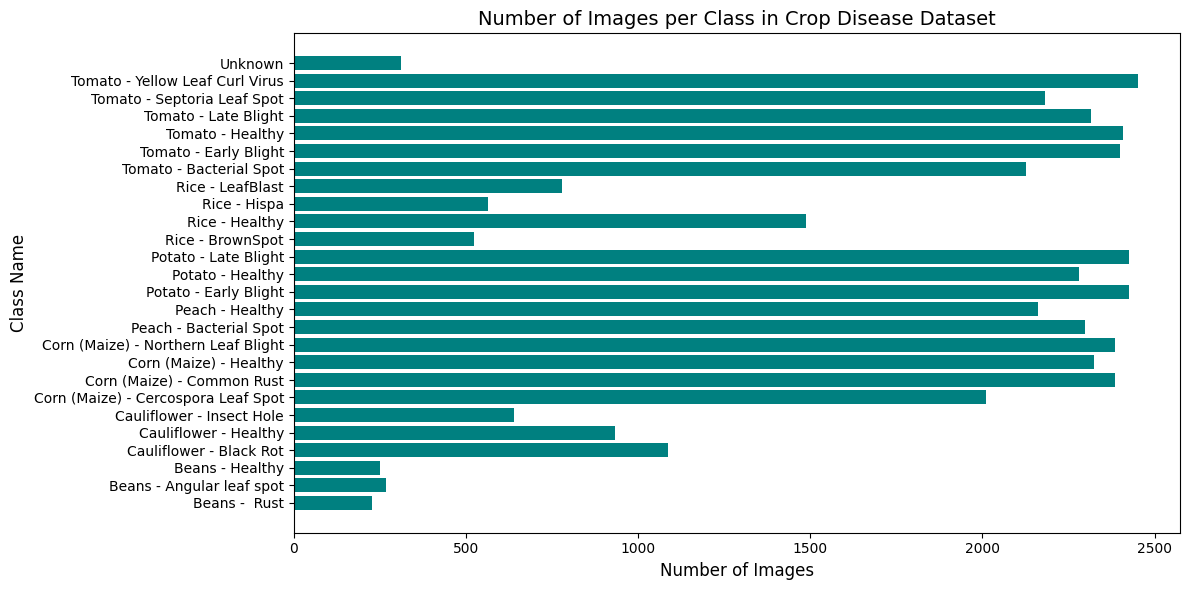

In [ ]:
# Visualization 
plt.figure(figsize=(12, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='teal')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class Name', fontsize=12)
plt.title('Number of Images per Class in Crop Disease Dataset', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Augmentation for training and normalization for validation
batch_size = 32
img_size = 224

CNN_train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training and validation generators (80% train, 20% val)
train_CNN = CNN_train_data.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_CNN = CNN_train_data.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

Found 33322 images belonging to 26 classes.
Found 8317 images belonging to 26 classes.
Classes: ['Beans -  Rust', 'Beans - Angular leaf spot', 'Beans - Healthy', 'Cauliflower - Black Rot', 'Cauliflower - Healthy', 'Cauliflower - Insect Hole', 'Corn (Maize) - Cercospora Leaf Spot', 'Corn (Maize) - Common Rust', 'Corn (Maize) - Healthy', 'Corn (Maize) - Northern Leaf Blight', 'Peach - Bacterial Spot', 'Peach - Healthy', 'Potato - Early Blight', 'Potato - Healthy', 'Potato - Late Blight', 'Rice - BrownSpot', 'Rice - Healthy', 'Rice - Hispa', 'Rice - LeafBlast', 'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Healthy', 'Tomato - Late Blight', 'Tomato - Septoria Leaf Spot', 'Tomato - Yellow Leaf Curl Virus', 'Unknown']


In [ ]:
# CNN Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


CNN_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_CNN.num_classes, activation='softmax')
])

CNN_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
CNN_model.summary()


c:\Users\user\OneDrive\Desktop\Year4,sem1\APC419\Project\croproject\cvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,251,354 (84.88 MB)

 Trainable params: 22,251,354 (84.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping 
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn_leaf_model.h5", monitor='val_accuracy', save_best_only=True)
]

# Train Model 
history = CNN_model.fit(
    train_CNN,
    validation_data=val_CNN,
    epochs=30,
    callbacks= callbacks
)

Epoch 1/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3351 - loss: 2.2620

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1570s 2s/step - accuracy: 0.4766 - loss: 1.7344 - val_accuracy: 0.6680 - val_loss: 1.0236
Epoch 2/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6495 - loss: 1.0989

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1603s 2s/step - accuracy: 0.6659 - loss: 1.0335 - val_accuracy: 0.7203 - val_loss: 0.8039
Epoch 3/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7114 - loss: 0.8742

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1573s 2s/step - accuracy: 0.7212 - loss: 0.8418 - val_accuracy: 0.7691 - val_loss: 0.6486
Epoch 4/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7466 - loss: 0.7586

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1635s 2s/step - accuracy: 0.7514 - loss: 0.7394 - val_accuracy: 0.7957 - val_loss: 0.5635
Epoch 5/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7692 - loss: 0.6827

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 3858s 4s/step - accuracy: 0.7741 - loss: 0.6629 - val_accuracy: 0.8040 - val_loss: 0.5301
Epoch 6/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7882 - loss: 0.6239

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 2173s 2s/step - accuracy: 0.7916 - loss: 0.6094 - val_accuracy: 0.8164 - val_loss: 0.5006
Epoch 7/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7994 - loss: 0.5678

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1710s 2s/step - accuracy: 0.8030 - loss: 0.5625 - val_accuracy: 0.8216 - val_loss: 0.4815
Epoch 8/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8083 - loss: 0.5425

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1215s 1s/step - accuracy: 0.8113 - loss: 0.5351 - val_accuracy: 0.8335 - val_loss: 0.4481
Epoch 9/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1530s 1s/step - accuracy: 0.8242 - loss: 0.5038 - val_accuracy: 0.8312 - val_loss: 0.4478
Epoch 10/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 23807s 23s/step - accuracy: 0.8280 - loss: 0.4855 - val_accuracy: 0.8252 - val_loss: 0.4552
Epoch 11/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8338 - loss: 0.4648

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1859s 2s/step - accuracy: 0.8359 - loss: 0.4585 - val_accuracy: 0.8453 - val_loss: 0.4034
Epoch 12/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8435 - loss: 0.4492

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1871s 2s/step - accuracy: 0.8452 - loss: 0.4417 - val_accuracy: 0.8602 - val_loss: 0.3562
Epoch 13/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1476s 1s/step - accuracy: 0.8467 - loss: 0.4312 - val_accuracy: 0.8419 - val_loss: 0.4072
Epoch 14/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1246s 1s/step - accuracy: 0.8513 - loss: 0.4159 - val_accuracy: 0.8524 - val_loss: 0.3767
Epoch 15/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1383s 1s/step - accuracy: 0.8541 - loss: 0.4050 - val_accuracy: 0.8495 - val_loss: 0.3906
Epoch 16/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1155s 1s/step - accuracy: 0.8599 - loss: 0.3887 - val_accuracy: 0.8593 - val_loss: 0.3529
Epoch 17/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8636 - loss: 0.3785

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1504s 1s/step - accuracy: 0.8638 - loss: 0.3772 - val_accuracy: 0.8610 - val_loss: 0.3454
Epoch 18/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8693 - loss: 0.3607

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1866s 2s/step - accuracy: 0.8668 - loss: 0.3683 - val_accuracy: 0.8669 - val_loss: 0.3333
Epoch 19/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1851s 2s/step - accuracy: 0.8732 - loss: 0.3528 - val_accuracy: 0.8600 - val_loss: 0.3566
Epoch 20/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 16423s 16s/step - accuracy: 0.8720 - loss: 0.3560 - val_accuracy: 0.8596 - val_loss: 0.3452
Epoch 21/30
 150/1042 ━━━━━━━━━━━━━━━━━━━━ 25:16 2s/step - accuracy: 0.8713 - loss: 0.3561

In [ ]:
# accuracy
loss1, acc1 = CNN_model.evaluate(val_CNN)
print(f"Validation Accuracy after retraining: {acc1*100:.2f}%")